<a href="https://colab.research.google.com/github/jhdavislab/wqbio2022/blob/main/wqbio2022_cryoem_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 3: Particle picking and averaging / cryo-em analysis in 2-D.
*Material developed by Prof. Joey Davis (jhdavis@mit.edu), and graduate students Barrett Powell (bmp@mit.edu) and Laurel Kinman (lkinman@mit.edu). More information available at: https://github.com/jhdavislab/wqbio2022*

## Importing our required libraries

In [ ]:
!pip install mrcfile

     |████████████████████████████████| 40 kB 11 kB/s 


In [ ]:
import mrcfile as mrcf #used to read/write mrc files - the standard format for all cryoEM data
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.feature import match_template
from skimage.feature import peak_local_max
import math


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Defining a few plotting parameters

In [ ]:
#####################################################
ang_px = 0.6575 #this was the pixel size used in the microscope...crazy, right?
proteasome_length_ang = 150 #this is approxiamately the length of the proteasome in angstroms
proteasome_length_px = proteasome_length_ang/ang_px #this is the length in pixels
#####################################################

## Defining a few useful functions to plot our images
* Time permitting, you can read through this function, but it is not critical for this module.
 * *If you do take the time, think about why we set the vmin and vmax the way we do - hint: try plotting a histogram of the pixel values in one of our images to think about why we need to narrow the range to see our images*

In [ ]:
def plot_micrograph(img, figsize=(8,8), axis=False, crange=1.0, ax=None, cmap='gray'):
    if ax is None:
      f, ax = plt.subplots(1,1, figsize=figsize) #this creates a figure for us
    img_mean = img.mean()
    img_std = img.std()
    ax.imshow(img, cmap=cmap, origin='lower', vmin=img_mean-crange*img_std, vmax=img_mean+crange*img_std)
    if not axis:
        ax.axis('off')
    return ax

## The value of motion correction
* We will first compare the summed movie we analyzed in part 1 to the output of cryoSPARC's motion correction
 * Note how much sharper the particles appear

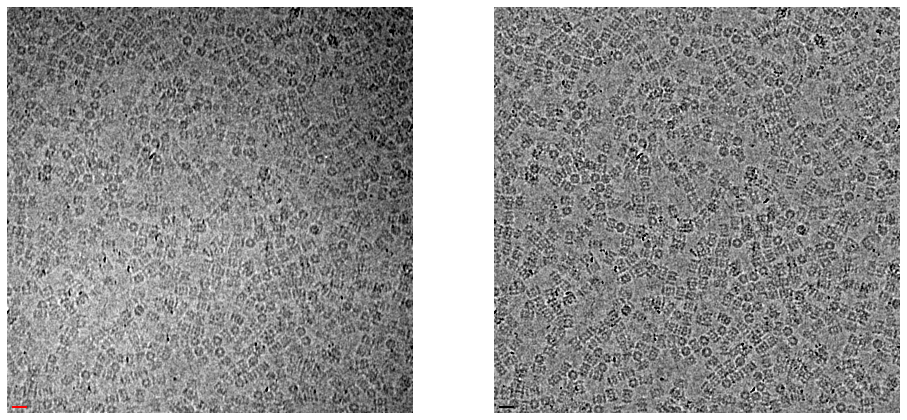

In [ ]:
summed_micrograph = mrcf.open('/content/drive/My Drive/qmw_cryoem_data/summed_movie.mrc').data[:7000,:7000]
motion_corrected = np.flip(mrcf.open('/content/drive/My Drive/qmw_cryoem_data/motion_no_dose.mrc').data, axis=0)[:7000,:7000] #note that cryosparc flips the axis, we flip it back here
f,axes = plt.subplots(1,2,figsize=(16,8))
axes[0] = plot_micrograph(ndimage.gaussian_filter(summed_micrograph, 10), figsize=(15,15), crange=3, ax=axes[0])
axes[1] = plot_micrograph(ndimage.gaussian_filter(motion_corrected, 10), figsize=(15,15), crange=3, ax=axes[1])
axes[0].plot([100,100+proteasome_length_px], [100,100], color='red', linewidth=2)
axes[1].plot([100,100+proteasome_length_px], [100,100], color='black', linewidth=2)

* We also see significant improvement in the power spectra


## The impact of motion correction on our power spectra

Here, we will quickly look at and analyze the power spectra from these two images to see how motion correction has improved our image.

We first define our requried FT functions as before

In [ ]:
#compute the Fourier transform and center it
def fft_center(img):
  f = np.fft.fft2(img) #this calculates the FT of our image - note that it is a complex output with real and imaginary components
  return np.fft.fftshift(f) #this shifts the origin to the center of the image

#shift the origin back away from the center and compute the inverse Fourier transform, return the real portion
def inv_fft(fft_cent):
  fft_shift = np.fft.ifftshift(fft_cent) #this shifts the center of the image back to the origin
  img = np.fft.ifft2(fft_shift) #this calculates the inverse FT
  return img.real

#calculate a power spectra given a centered Fourier transformed image
def ps_center(fft_cent):
  ps = np.abs(fft_cent)**2 #this line calculates the power spectra, which is the magnitude of the FT
  return np.log(ps) #we take the log to better visualize the small amplitude components.

Next, we select a window focused on the range where we expect to observe Thon rings

In [ ]:
full_width = summed_micrograph.shape[0]
zoom_range = 2000
window_low = int((full_width-zoom_range)/2)
window_high = int((full_width+zoom_range)/2)

Finally, we compute our power spectra and plot them

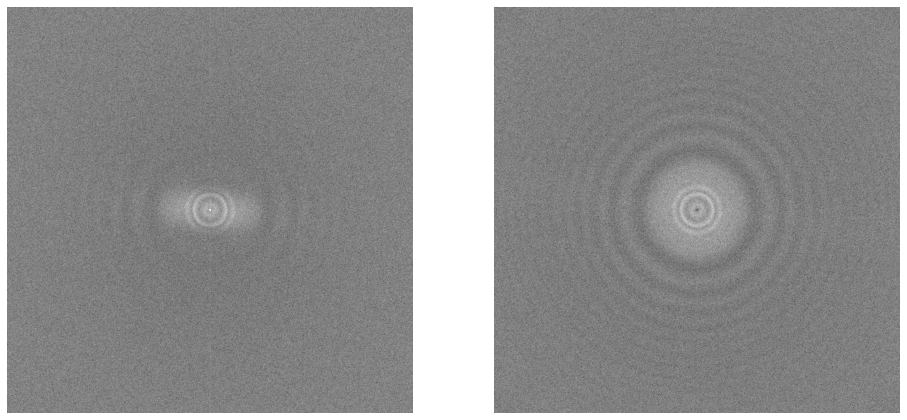

In [ ]:
f,axes = plt.subplots(1,2,figsize=(16,8))
fft_cent_sum = fft_center(summed_micrograph)
ps_sum = ps_center(fft_cent_sum)

fft_cent_mot = fft_center(motion_corrected)
ps_mot = ps_center(fft_cent_mot)

plot_micrograph(ps_sum[window_low:window_high,window_low:window_high], crange=3, ax=axes[0], cmap='gray')
plot_micrograph(ps_mot[window_low:window_high,window_low:window_high], crange=3, ax=axes[1], cmap='gray')

 **Describe the improvement(s) you see, and how those improvements might contribute to our ability to determine a high resolution structure**

## Optional section - Estimating the Contrast Transfer Function

One simple interpretation of these power spectra is as a very complicated band pass filter - the contrast of some frequencies is dampened, and the contrast of others is completely inverted. Below, we calculate a radial average of this plot to view the curve I am describing.

In [ ]:
def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return (radialprofile-radialprofile.mean())*-1

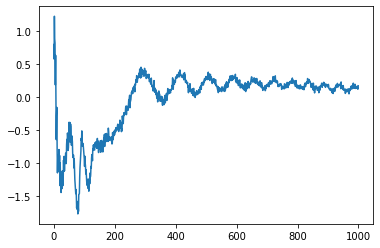

In [ ]:
focused_ps = ps_mot[window_low:window_high,window_low:window_high]
plt.plot(np.arange(1000), radial_profile(focused_ps, (1000,1000))[:1000])

* Notice the oscillations in the curve. It turns out we can fit that curve, and if we did, we can largely correct for it. This is known as CTF correction, and you can learn more about it below.

 **Optional**
  * Read more about the CTF here: https://cryoem101.org/chapter-5/#part3
  * Watch Grant Jensen's CTF videos here: https://www.youtube.com/watch?v=mPynoF2j6zc&t=2s

# Particle picking

As a final exercise, we will implement a simple particle picker to identify particles in our micrograph.

We will use a function already implemented in SciPy that relies on calculating cross correlation between your template image and regions of the micrograph. You can think of this as effectively rasterizing the template along the micrograph, and at each position, calculating how similar the template is to that region of the micrograph. Thus, at each position in the micrograph, we have a value of how similar the template was to the image (with larger values indicating greater similarity. We will then pick out "peaks" from this landscape, and will extract particles from those peaks.

Note that this approach only translates the template along the micrograph and does not rotate it.

**Discuss about why translating but not rotating the template may be sub-optimal for our application, and whether this will impact some templates more than others**

We will start by opening a series of 2D class averages (you can think of these as 2D projections of the proteasome that we have calculated elsewhere).

In [ ]:
class_averages = mrcf.open('/content/drive/My Drive/qmw_cryoem_data/class_averages.mrc').data

Here, we write a small function to plot the class averages

In [ ]:
def plot_classes(class_averages, figsize=(12.5,10), num_cols=5):
  num_classes = class_averages.shape[0]
  num_rows = math.ceil(num_classes/num_cols)
  f,axes = plt.subplots(num_rows, num_cols, figsize=figsize)
  axes = axes.flatten()
  for c in range(num_classes):
    axes[c].imshow(class_averages[c,:,:], cmap='gray', origin='lower')
    axes[c].axis('off')

  plt.tight_layout()

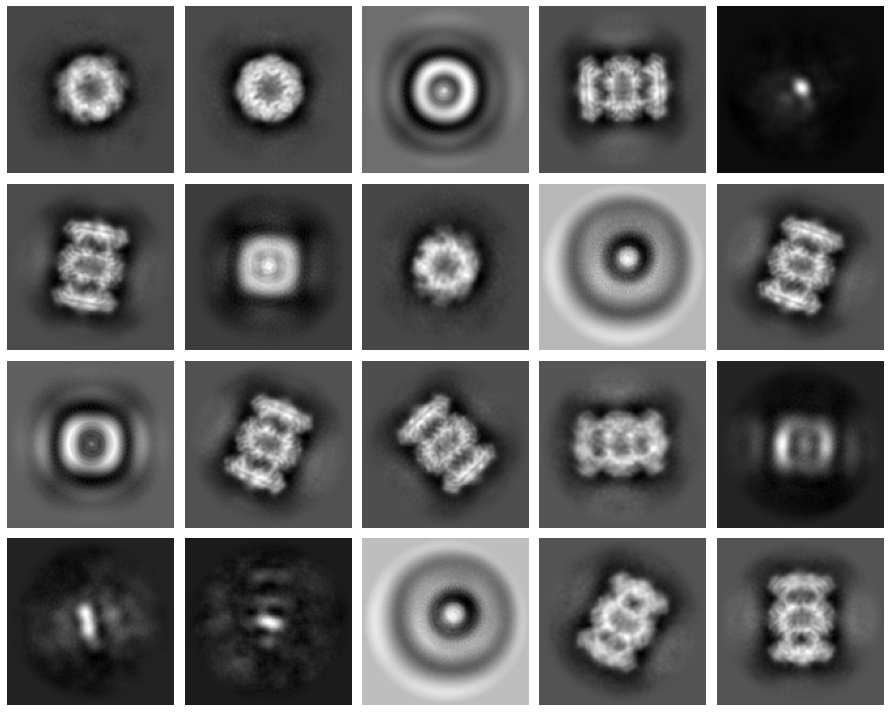

In [ ]:
plot_classes(class_averages)

**Do these class averages capture some of the views of the proteasome you've seen in the earlier sections of the workshop?**

Next, we choose a single template. 

**Notice that I have inverted the contrast - how have I done that?**

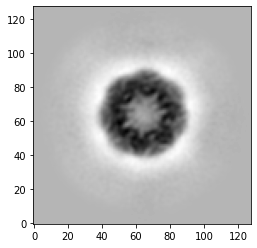

In [ ]:
template = class_averages[1,:,:]*-1
f,ax = plt.subplots(1,1)
ax.imshow(template,cmap='gray', origin='lower')

Next, we need to correctly "size" our template. When we had calculated these 2D averages in cryoSPARC (which you will do yourselves), we strongly downsampled the micrographs by fourier cropping them to save on computational resources. Here, we need to crop our real micrographs so that the template is sized correctly relative to the micrograph.

**Based on the previous workshop sections, you should be able to understand all of the following code**

In [ ]:
def fourier_crop(img, factor):
  fft_cent = fft_center(img)
  full_width = img.shape[0]
  crop_width = int(full_width/factor)
  window_low = int((full_width-crop_width)/2)
  window_high = int((full_width+crop_width)/2)
  recovered_image_ft_crop = inv_fft(fft_cent[window_low:window_high,window_low:window_high])
  return recovered_image_ft_crop

In [ ]:
original_box = 440 #this was the box size in pixels in the original micrograph
final_box = 128 #this is the box size of our 2D class averages
crop_factor = original_box/final_box #Think through this line - does it make sense why this is the Fourier crop factor?
motion_corrected_crop = fourier_crop(motion_corrected, crop_factor) #apply the crop

Let's now look at the result of cropping, and see if it makes sense

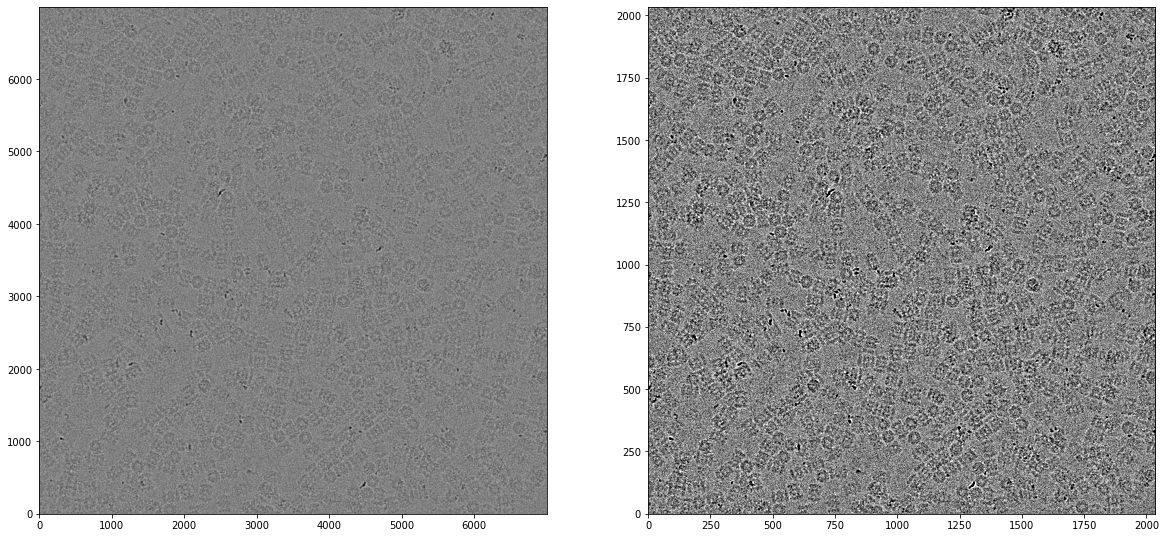

In [ ]:
f,ax = plt.subplots(1,2, figsize=(20,10))
ax[0] = plot_micrograph(motion_corrected, figsize=(15,15), crange=1, ax=ax[0], axis=True)
ax[1] = plot_micrograph(motion_corrected_crop, figsize=(15,15), crange=1, ax=ax[1], axis=True)

Here, we perform the template matching, calculating a normalized cross correlation between the 128x128 pixel template and every 128x128 pixel region within in the ~2000x2000 pixel micrograph.

We plot the result of this matching algorithm on the left, and the original micrograph on the right.

 * *Note that we have plotted a subset of the micrographs because the rasterizing does not extend all th way to the edges*

**What do you notice about the match result. What types of particles are we picking?**

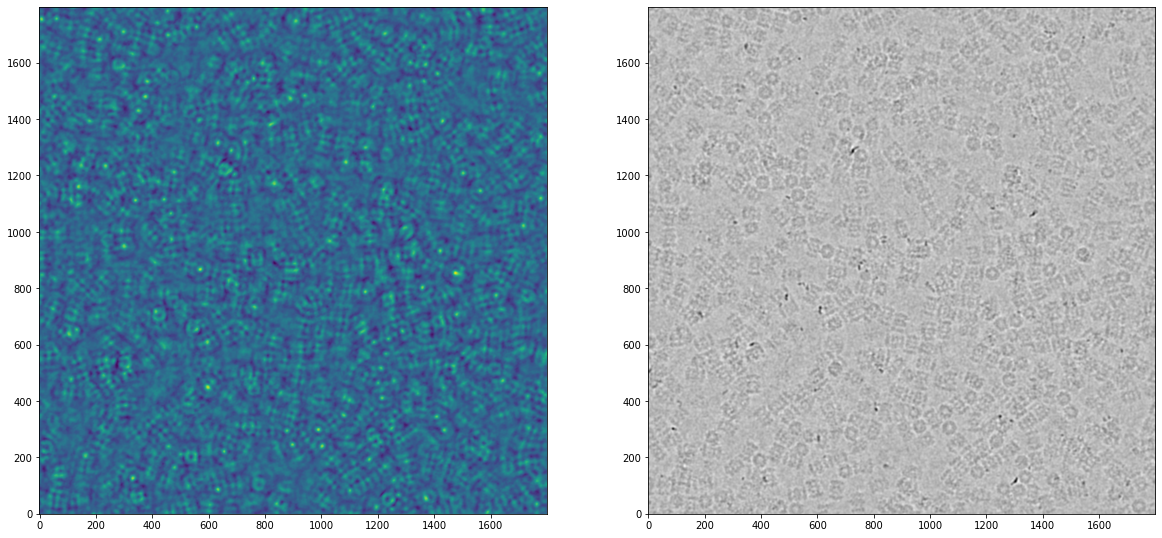

In [ ]:
match_image = match_template(motion_corrected_crop,template)
f, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(match_image[0:1800, 0:1800], origin='lower')
ax[1].imshow(ndimage.gaussian_filter(motion_corrected_crop[0:1800, 0:1800],3), origin='lower', cmap='gray')

Next, we inpsect the range of correlation values using a histogram

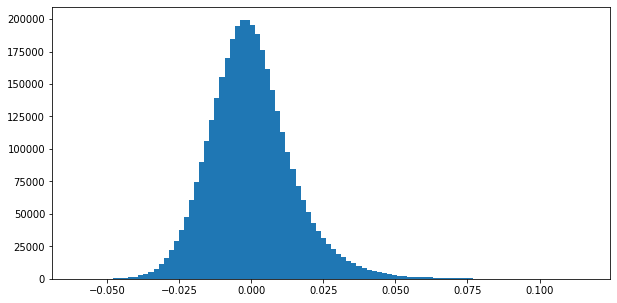

In [ ]:
f,ax = plt.subplots(1,1,figsize=(10,5))
_ = ax.hist(match_image.flatten(), bins=100)

And we choose a relatively stringent threshold as our cutoff

In [ ]:
thresh = 0.07

Next, we plot our particle picks on the micrograph.

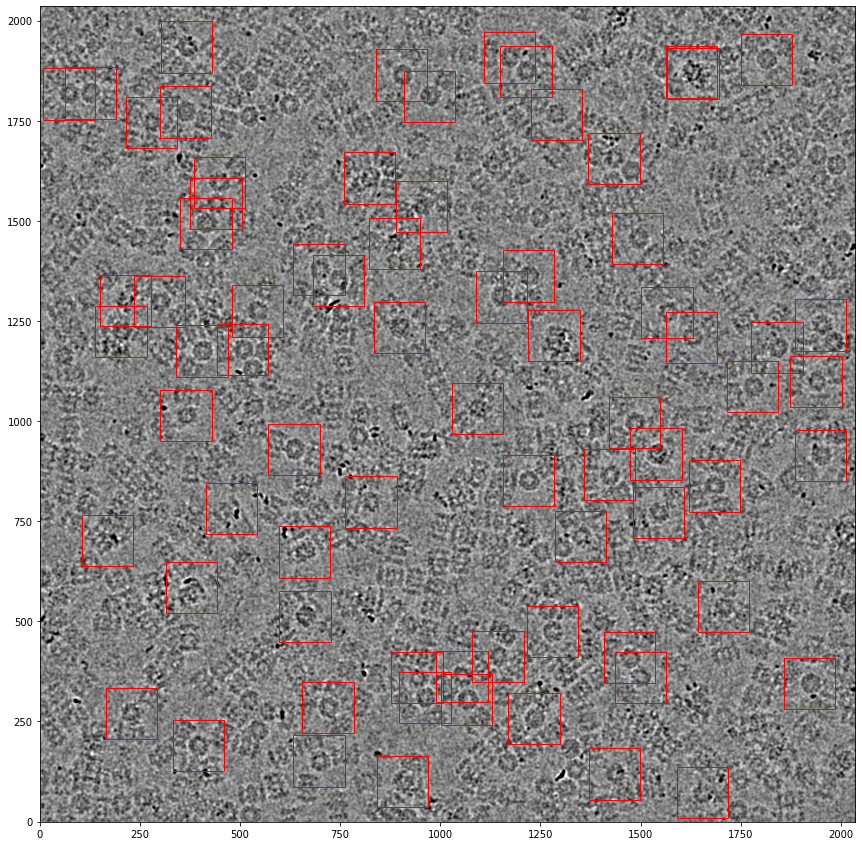

In [ ]:
template_width, template_height = template.shape    
f,ax = plt.subplots(1,1,figsize=(15, 15))
ax = plot_micrograph(ndimage.gaussian_filter(motion_corrected_crop, 2), crange=4, ax=ax, axis=True)
for x, y in peak_local_max(match_image, threshold_abs=thresh):
    rect = plt.Rectangle((y, x), template_height, template_width,
                          color='r', fc='none')
    ax.add_patch(rect)

**Cool, right!!**

 * **Look closely at the picks we've make.**

 * **What types of particles are we finding, what types are we missing?** 

 * **Are there other issues with this simple peak picking approach?**

 * **Is it a problem that we have overlapping picks, why or why not?**

Finally, we will extract and plot a subset of our particles using the function below

 * **If you have time, read throught thse functions and see if you can make sense of them**

In [ ]:
def extract_particles(micrograph, match_image, template, threshold):
  w, h = template.shape
  particle_stack = np.zeros((w,h))
  for x, y in peak_local_max(match_image, threshold_abs=threshold):
    current_match = micrograph[x:x+w, y:y+w]
    particle_stack = np.dstack((particle_stack,current_match))
  return particle_stack[:,:,1:]

def plot_particles(particle_stack):
  f,axes = plt.subplots(3,3,figsize=(6,6))
  axes = axes.flatten()
  for i in range(9):
    axes[i] = plot_micrograph(ndimage.gaussian_filter(particle_stack[:,:,i], 1), crange=3, ax=axes[i])
  plt.tight_layout()

In [ ]:
particle_stack = extract_particles(motion_corrected_crop, match_image, template, thresh)

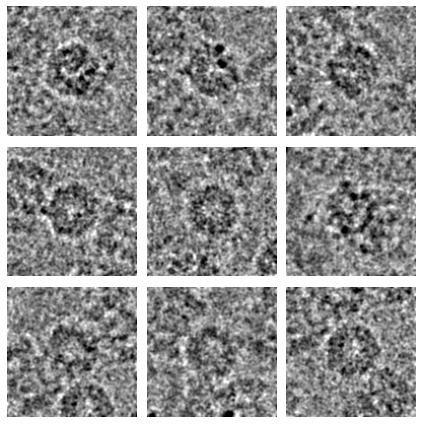

In [ ]:
plot_particles(particle_stack)

These images show us individual particles. Let's see what happens if we sum all of these particles.

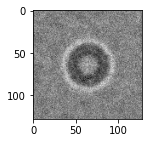

In [ ]:
f,ax = plt.subplots(1,1,figsize=(2,2))
ax.imshow(np.sum(particle_stack, axis=2), cmap='gray')

**Neat, right?**

* **What do you notice about the resulting sum?**
 * *Hint: Note that we do not consider any rotations in our template picking search, and we do not rotate our particles to align them when summing. What has this done to our picked particle stack relative to our initial template?*

## Great job, hope you've enjoyed working through these examples!

**If you have remaining time, you can**

* **1. Work through the optional (but very cool) Einstein from noise example at the bottom of this notebook**
 * I strongly suggest everyone work through this if you have time.

* **2. Try template picking with a different template (e.g. one of the barrels).**
 * *Hint: you will want to define some functions to streamline this process. Once you do so, you can quickly try different templates.*
 * **Think about why our particle picking method works better or worse depending on the template we choose**
   * *Hint: note that we do no consider any rotations of our template, and also think carefuly about the various symmetry axes in a D7 symmetric molecule (learn more [here](https://blake.bcm.edu/emanwiki/EMAN2/Symmetry))*

**Finally, think a bit about some of defects of our approach.**
 * **What approaches can we use to convince ourselves that we are not extracting "Einstein from noise" with a template picking approach**
  * *Hint: Think about how we might remove "information" that we expect to be there based on prior knowledge (e.g. protein secondary structure) from our template and then see if that information manifests in our particles* 

* **Have we considered the CTF at all? If so, how, if not, how have we not?**
 * **How might we create a better template picker if we wanted to include the CTF?**




## Optional 1. Einstein from noise (optional, but cool, I promise)
In this final optional section, we highlight the potential issues/model bias that template matching can introduce. This example is based on the this lovely paper from Nobel Laureate Richard Henderson (https://www.pnas.org/content/110/45/18037)

we will start with a 64x64 template based on the MIT logo

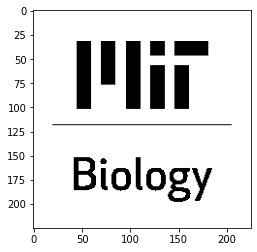

In [ ]:
from PIL import Image
template = np.asarray(Image.open('/content/drive/My Drive/qmw_cryoem_data/mit.bmp'))
f,ax = plt.subplots(1,1)
ax.imshow(template,cmap='gray')

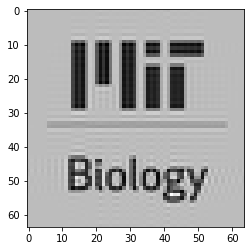

In [ ]:
original_box = 225 #this was the box size in pixels in the original micrograph
final_box = 64 #this is the box size of our 2D class averages
crop_factor = original_box/final_box #Think through this line - does it make sense why this is the Fourier crop factor?
template_cropped = fourier_crop(template, crop_factor) #apply the crop
f,ax = plt.subplots(1,1)
ax.imshow(template_cropped,cmap='gray')

We now generate an ~20 mock micrograph containing only noise. Note that a real experiment would have micrographs ~4-fold larger, and might have ~100-fold more micrographs!

In [ ]:
sigma = 1
dim = 2000
num_micrographs = 20
thresh = 0.07

particle_stack = np.zeros((final_box,final_box))
total_particles = 0
for mic in range(num_micrographs):
  print('micrograph: '+str(mic))
  mock_micrograph = np.random.normal(0, sigma, (dim,dim))
  match_image = match_template(mock_micrograph,template_cropped)
  new_particles = extract_particles(mock_micrograph, match_image, template_cropped, thresh)
  p_count = new_particles.shape[2]
  print('found ' + str(p_count) + ' new particles.')
  particle_stack = np.dstack((particle_stack,new_particles))
  total_particles+=p_count
particle_stack = particle_stack[:,:,1:]

print('\nfound ' + str(particle_stack.shape[2]) + ' total particles.')

micrograph: 0
found 13 new particles.
micrograph: 1
found 11 new particles.
micrograph: 2
found 14 new particles.
micrograph: 3
found 13 new particles.
micrograph: 4
found 14 new particles.
micrograph: 5
found 10 new particles.
micrograph: 6
found 6 new particles.
micrograph: 7
found 8 new particles.
micrograph: 8
found 12 new particles.
micrograph: 9
found 12 new particles.
micrograph: 10
found 8 new particles.
micrograph: 11
found 13 new particles.
micrograph: 12
found 8 new particles.
micrograph: 13
found 9 new particles.
micrograph: 14
found 17 new particles.
micrograph: 15
found 19 new particles.
micrograph: 16
found 10 new particles.
micrograph: 17
found 13 new particles.
micrograph: 18
found 16 new particles.
micrograph: 19
found 7 new particles.

found 233 total particles.


Let's now look at the individual "particles". Do you see any patterns? No? Me neither...I guess this isn't really a problem :)

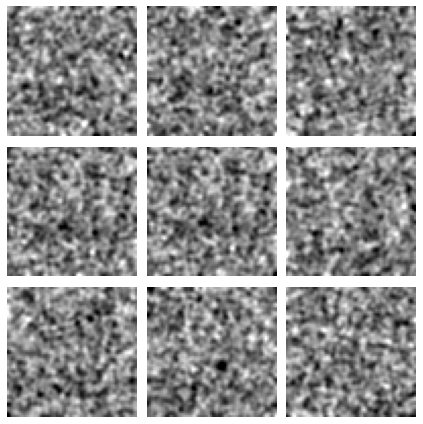

In [ ]:
plot_particles(particle_stack)

To be sure, let's just quickly sum all of our particles and see if anything emerges.

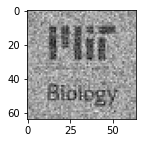

In [ ]:
f,ax = plt.subplots(1,1,figsize=(2,2))
ax.imshow(np.sum(particle_stack, axis=2), cmap='gray')

#Yikes!
* Try and remember this result anytime you are "searching" for signal in very noisy data, and re-read the linked PNAS paper to consider approaches to avoid the "Einstein from noise" pitfalls!

## Optional 2: (semi)-automated Template picking

In [ ]:
#First, write some functions to:
#1. Choose a class
#2. Perform the template matching
#3. Plot your picks

########################################################
#SOLUTION
def choose_class(class_averages, class_number):
  template = class_averages[class_number,:,:]*-1
  f,ax = plt.subplots(1,1)
  ax.imshow(template,cmap='gray', origin='lower')
  return template

def template_match(motion_corrected_crop, template):
  match_image = match_template(motion_corrected_crop,template)
  f, ax = plt.subplots(1,3, figsize=(15,5))
  ax[0].imshow(match_image[0:1800, 0:1800], origin='lower')
  ax[1].imshow(ndimage.gaussian_filter(motion_corrected_crop[0:1800, 0:1800],3), origin='lower', cmap='gray')
  _ = ax[2].hist(match_image.flatten(), bins=100)
  return match_image

def plot_picks(motion_corrected_crop, match_image, template, thresh):
  template_width, template_height = template.shape    
  f,ax = plt.subplots(1,1,figsize=(15, 15))
  ax = plot_micrograph(ndimage.gaussian_filter(motion_corrected_crop, 2), crange=4, ax=ax, axis=True)
  for x, y in peak_local_max(match_image, threshold_abs=thresh):
    rect = plt.Rectangle((y, x), template_height, template_width,color='r', fc='none')
    ax.add_patch(rect)
########################################################

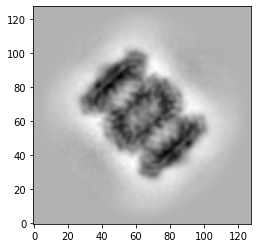

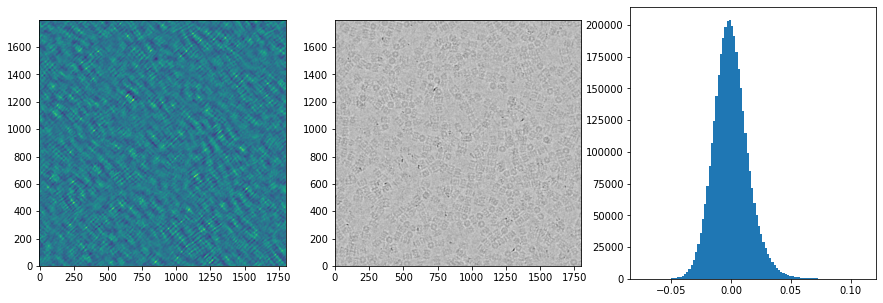

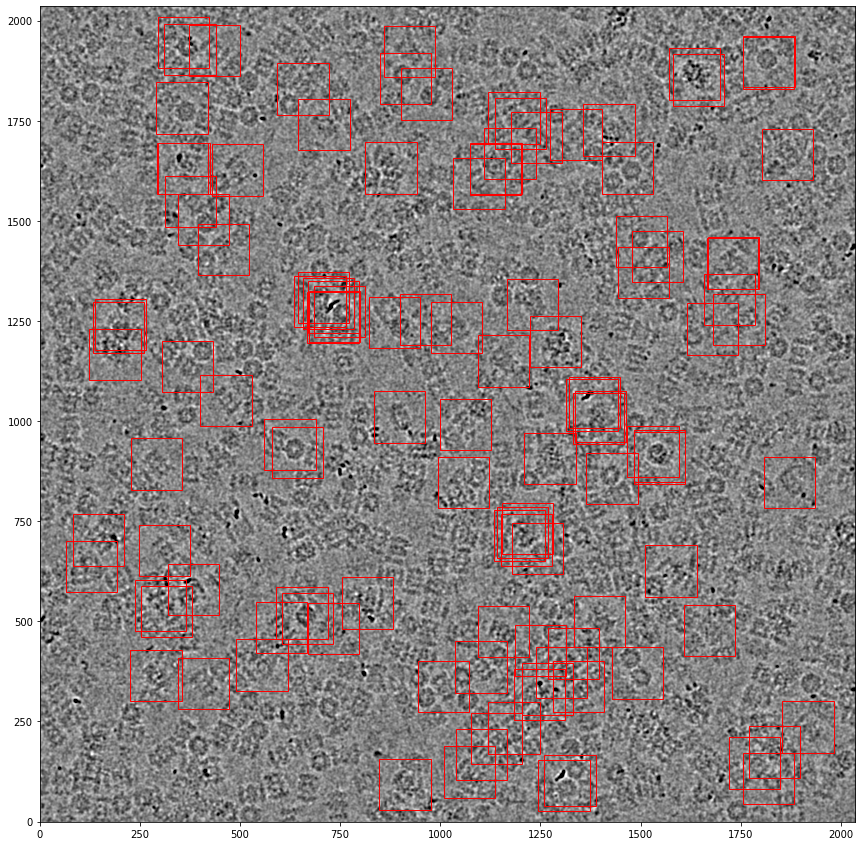

In [ ]:
#Fill me in using your functions form above to 
#1. Choose your class, perform the matching
#2. Next, choose a suitable threshold
#3. Plot your picks, extract your particles, and plot a few representative ones
#4. Finally, calculate your particle stack sum
########################################################
#SOLUTION
template = choose_class(class_averages, 12)
match_image = template_match(motion_corrected_crop, template)
thresh=0.06
plot_picks(motion_corrected_crop, match_image, template, thresh)
########################################################


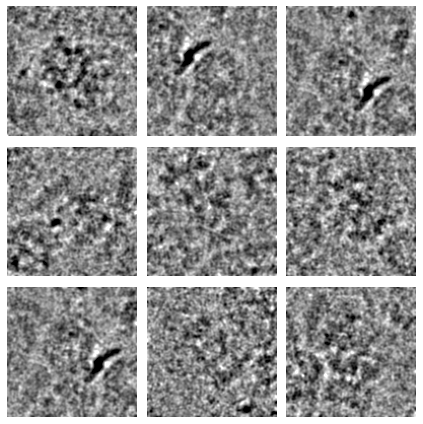

In [ ]:
#Fill me in to extract a particle stack and plot those particles using your functions

########################################################
#SOLUTION
particle_stack = extract_particles(motion_corrected_crop, match_image, template, thresh)
plot_particles(particle_stack)
########################################################


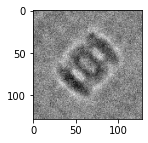

In [ ]:
#Finally, fill me in to plot a the sum of our extracted particle stack

########################################################
#SOLUTION
f,ax = plt.subplots(1,1,figsize=(2,2))
ax.imshow(np.sum(particle_stack, axis=2), cmap='gray')
########################################################